In [60]:
# Run this if yfinance is not installed
# !pip install yfinance
# !conda install -y -c conda-forge tensorboard

^C


In [61]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader, TensorDataset

In [4]:
def download(ticker = "^GSPC", start_date = None, end_date = None, price = ["Adj Close", "Close", "High", "Low", "Open", "Volume"]):
    df = yf.download(ticker, start = start_date, end = end_date)
    return df[price]

In [5]:
class YahooDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data)
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Config

In [6]:
# ticker = "AAPL, ^GSPC, AMZN"
start_date = "2023-02-01"
end_date = "2024-02-01"
price = 'Close'

batch_size = 64

# Data preparation: generating training and test datasets

In [44]:
df = download(ticker = "^GSPC", start_date = start_date, end_date = end_date, price = price)
date = df.index.strftime("%Y/%m/%d")

split_index = int(len(date)*0.8)
train = df[:split_index]
test = df[split_index:]

train = YahooDataset(train)
test = YahooDataset(test)

df.describe()

[*********************100%%**********************]  1 of 1 completed


count     251.000000
mean     4353.042036
std       249.728969
min      3855.760010
25%      4137.260010
50%      4369.009766
75%      4515.320068
max      4927.930176
Name: Close, dtype: float64

<Axes: xlabel='Date'>

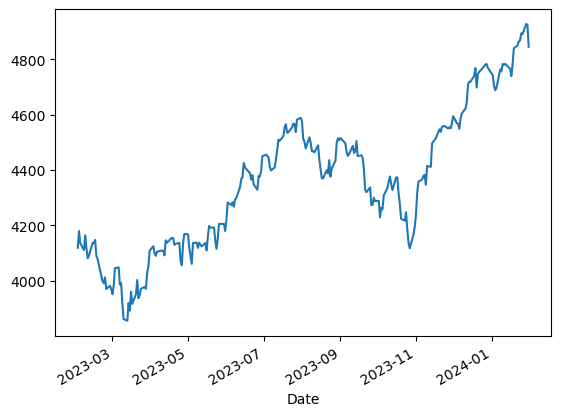

In [45]:
df.plot()

In [9]:
train_loader = DataLoader(train, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)
for i, batch in enumerate(train_loader):
    print(batch)

tensor([4399.7700, 4496.8301, 4582.2300, 4229.4502, 4133.5200, 4169.4800,
        4567.4600, 4136.4800, 4478.0298, 4217.0400, 4446.8198, 3951.5701,
        4273.5298, 4378.3799, 4467.4399, 4487.4600, 4337.4399, 4499.3799,
        4314.6001, 4465.4800, 4382.7798, 3951.3899, 4348.3301, 4514.8701,
        4327.7798, 4091.9500, 4338.9302, 4293.9302, 4119.2100, 4258.1899,
        3991.0500, 4451.1401, 4534.8701, 4288.3901, 4138.1201, 4576.7300,
        4565.7202, 4283.8501, 4050.8301, 4267.5200, 4335.6602, 4151.2798,
        4045.6399, 4436.0098, 4404.3301, 4388.7100, 4330.0000, 3948.7200,
        4513.3901, 4205.4502, 3992.0100, 4109.1099, 4472.1602, 4369.0098,
        4464.0498, 4237.8599, 4137.6401, 4136.2500, 4282.3701, 4349.6099,
        4497.6299, 4402.2002, 4263.7500, 4105.0200], dtype=torch.float64)
tensor([3981.3501, 4027.8101, 4179.8301, 3919.2900, 4071.6299, 3986.3701,
        4137.2900, 4381.8901, 4439.2598, 4130.6201, 4369.7100, 4119.5801,
        4205.5200, 4347.3501, 4288.049

In [63]:
class Generator(nn.Module):
    def __init__(self, z_dim, hidden_size, output_size):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(z_dim, hidden_size),
            nn.LeakyReLU(0.1),
            nn.Linear(hidden_size, output_size),
            nn.Tanh()
        )
        
    def forward(self, x):
        return self.fc(x)
    
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Discriminator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.LeakyReLU(0.1),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.fc(x)

In [68]:
lr = 3e-4  # Learning rate
z_dim = 100
batch_size = 32
data_dim = 32
g_hidden_size = 20
d_hidden_size = 50
num_epoches = 50

In [67]:
gen = Generator(z_dim, g_hidden_size, data_dim)
disc = Discriminator(data_dim, d_hidden_size)
opt_gen = optim.Adam(gen.parameters(), lr=lr)
opt_disc = optim.Adam(disc.parameters(), lr=lr)
criterion = nn.BCELoss()
step = 0

In [ ]:
for epoch in range(num_epoches):
    for batch_ind, (real, _) in enumerate(train_loader):
        real = real.view(-1, 8)
        batch_size = real.shape[0]
        
        ### Train Disc
        noise = torch.randn(batch_size, z_dim)
        fake = gen(noise)
        disc_real = disc(real).view(-1)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake).view(-1)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        lossD = (lossD_real + lossD_fake) / 2
        disc.zero_grad()
        lossD.backward()
        opt_disc.step()
        
        ### Train Gen
        output = disc(fake).view(-1)
        lossG = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        lossG.backward()
        opt_gen.step()
        

In [75]:
batch.view(-1, 4)

tensor([[3891.9299, 4320.0601, 4278.0000, 4193.7998],
        [4147.6001, 4137.0400, 4415.2402, 4108.9399]], dtype=torch.float64)

In [74]:
batch

tensor([3891.9299, 4320.0601, 4278.0000, 4193.7998, 4147.6001, 4137.0400,
        4415.2402, 4108.9399], dtype=torch.float64)